In [2]:
import pandas
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

Обозначим глобальные переменные. Входной размер изображений - 224х224

In [3]:
input_shape = (224, 224)
categories_num = 37
batch_size = 32

Создадим генераторы для обучения сети. Data augmentation будет применться только в одном эксперименте.

In [4]:
train_data = pandas.read_csv('../train_pets.csv', usecols=['Category', 'Path'])
val_data = pandas.read_csv('../val_pets.csv', usecols=['Category', 'Path'])

train_datagen = ImageDataGenerator(
        rescale=1. / 255,
#         rotation_range=10,
#         zoom_range=0.1,
#         brightness_range=(0.7, 1.3),
#         horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

Found 6434 validated image filenames belonging to 37 classes.
Found 333 validated image filenames belonging to 37 classes.


In [5]:
def plot_history(histories, save=False, folder=""):
    # Plot training & validation accuracy values
    plt.figure(1)
    for i in range(len(histories)):
        plt.plot(histories[i].history['categorical_accuracy'])
        plt.plot(histories[i].history['val_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.figure(2)
    for i in range(len(histories)):
        plt.plot(histories[i].history['loss'])
        plt.plot(histories[i].history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

Метод для создания модели. Возможны следующие варианты:
 - стек простых сверточных слоев с активацией ReLU
 - слой *BatchNormalization* после каждой вертки
 - слой *Dropout(0.7)* перед слоем классификации
 - слой *GlobalAveragePooling2D* вместо дополнительного полносвязного слоя
 
Также присутствует параметр *lr* для корректировки learning rate в оптимизаторе Adam.

In [6]:
from keras import Sequential
from keras.layers import *
from keras.metrics import categorical_accuracy
from keras.optimizers import Adam
from keras.utils import plot_model

def conv_model(size=1, lr=0.001, use_dropout=False, use_batchnorm=False, use_globalpool=False):
    model = Sequential()
    image_inputs = Input(shape=(input_shape[0], input_shape[1], 3,))
    
    model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='same',
                     input_shape=(input_shape[0], input_shape[1], 3,)))
    if use_batchnorm:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D((2, 2)))
    
    for i in range(size-1):
        model.add(Conv2D(128*(2**i), (3, 3), padding='same'))
        if use_batchnorm:
            model.add(BatchNormalization())
        model.add(Activation('relu'))
                      
        model.add(Conv2D(128*(2**i), (3, 3), padding='same'))
        if use_batchnorm:
            model.add(BatchNormalization())
        model.add(Activation('relu'))
                      
        model.add(MaxPooling2D((2, 2)))

    if use_globalpool:
        model.add(GlobalAveragePooling2D())
    else:
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
    
    if use_dropout:
        model.add(Dropout(0.7))     
    
    model.add(Dense(units=categories_num, activation='softmax'))
    
    model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=[categorical_accuracy])
    return model

### Первый вариант модели

In [12]:
model = conv_model(size=2, lr=0.0003, use_dropout=False, use_batchnorm=False, use_globalpool=False)
model.summary()

# plot_model(model, to_file='size=2,lr=0.001,use_dropout=False,use_batchnorm=False,use_globalpool=False.png',
#            show_shapes=False, show_layer_names=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
activation_7 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
activation_8 (Activation)    (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 128)       147584    
_________________________________________________________________
activation_9 (Activation)    (None, 56, 56, 128)       0         
__________

Epoch 1/100
 - 19s - loss: 3.6011 - categorical_accuracy: 0.0392 - val_loss: 3.5296 - val_categorical_accuracy: 0.0465
Epoch 2/100
 - 16s - loss: 3.2629 - categorical_accuracy: 0.1222 - val_loss: 3.1931 - val_categorical_accuracy: 0.1362
Epoch 3/100
 - 16s - loss: 2.6147 - categorical_accuracy: 0.2836 - val_loss: 3.4794 - val_categorical_accuracy: 0.1462
Epoch 4/100
 - 16s - loss: 1.6516 - categorical_accuracy: 0.5348 - val_loss: 3.8540 - val_categorical_accuracy: 0.1827
Epoch 5/100
 - 16s - loss: 0.6590 - categorical_accuracy: 0.8117 - val_loss: 5.6533 - val_categorical_accuracy: 0.1794
Epoch 6/100
 - 16s - loss: 0.1812 - categorical_accuracy: 0.9557 - val_loss: 6.9299 - val_categorical_accuracy: 0.1362
Epoch 7/100
 - 16s - loss: 0.0586 - categorical_accuracy: 0.9863 - val_loss: 7.2820 - val_categorical_accuracy: 0.1628
Epoch 8/100
 - 16s - loss: 0.0332 - categorical_accuracy: 0.9928 - val_loss: 7.6288 - val_categorical_accuracy: 0.2027
Epoch 9/100
 - 17s - loss: 0.0315 - categorical_

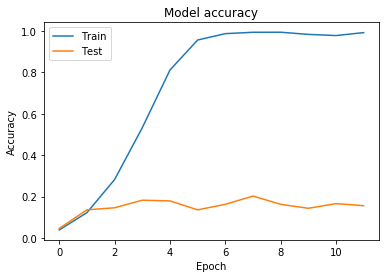

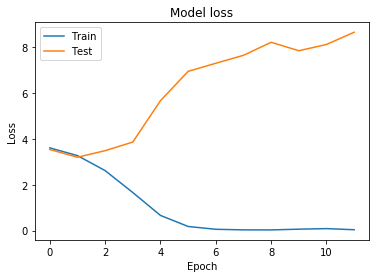

In [13]:
early_stop = EarlyStopping(patience=10)

history_1 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=100,
            verbose=2,
            callbacks=[early_stop])

plot_history([history_1])

Наблюдается сильное переобучение. Попробуем использовать батч нормализацию и замеим слой Dense на GlobalPooling. Также попробуем увеличить общее количество слоев.

### Второй вариант модели

In [16]:
model = conv_model(size=3, lr=0.0003, use_dropout=False, use_batchnorm=True, use_globalpool=True)
model.summary()

# plot_model(model, to_file='size=3,lr=0.001,use_dropout=False,use_batchnorm=True,use_globalpool=True.png',
#            show_shapes=False, show_layer_names=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_6 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_15 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 56, 56, 128)       512       
_________________________________________________________________
activation_16 (Activation)   (None, 56, 56, 128)       0         
__________

Epoch 1/100
 - 23s - loss: 3.4769 - categorical_accuracy: 0.0798 - val_loss: 3.5550 - val_categorical_accuracy: 0.0594
Epoch 2/100
 - 21s - loss: 3.1910 - categorical_accuracy: 0.1308 - val_loss: 4.3196 - val_categorical_accuracy: 0.0930
Epoch 3/100
 - 20s - loss: 2.9976 - categorical_accuracy: 0.1900 - val_loss: 3.7294 - val_categorical_accuracy: 0.0465
Epoch 4/100
 - 20s - loss: 2.8465 - categorical_accuracy: 0.2245 - val_loss: 3.4832 - val_categorical_accuracy: 0.1196
Epoch 5/100
 - 20s - loss: 2.7102 - categorical_accuracy: 0.2545 - val_loss: 3.4140 - val_categorical_accuracy: 0.1196
Epoch 6/100
 - 20s - loss: 2.5861 - categorical_accuracy: 0.2898 - val_loss: 3.4414 - val_categorical_accuracy: 0.0698
Epoch 7/100
 - 20s - loss: 2.4747 - categorical_accuracy: 0.3089 - val_loss: 4.6221 - val_categorical_accuracy: 0.0731
Epoch 8/100
 - 20s - loss: 2.3631 - categorical_accuracy: 0.3492 - val_loss: 3.8067 - val_categorical_accuracy: 0.1761
Epoch 9/100
 - 20s - loss: 2.2779 - categorical_

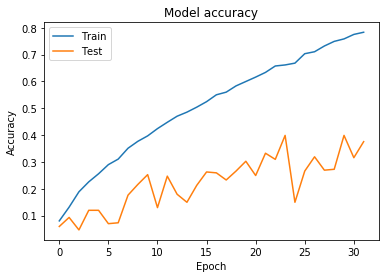

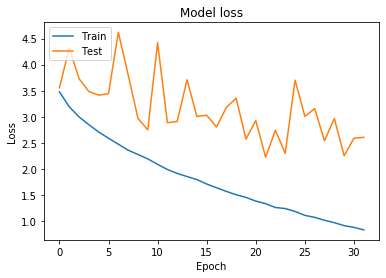

In [17]:
early_stop = EarlyStopping(patience=10)

history_2 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=100,
            verbose=2,
            callbacks=[early_stop])

plot_history([history_2])

Переобучение снизилось. Точность на тренировочной выборке возросла до 0,68. Сходится модель намного быстрее благодаря слоям батч нормализации. Попробуем добавть дроаут перед слоем классификации, чтобы еще снизить переобучение.

In [18]:
model.save('2.h5')

### Третий вариант модели

In [28]:
model = conv_model(size=3, lr=0.001, use_dropout=True, use_batchnorm=True, use_globalpool=True)
model.summary()

plot_model(model, to_file='size=3,lr=0,001,use_dropout=True,use_batchnorm=True,use_globalpool=True',
           show_shapes=False, show_layer_names=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_11 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_42 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
batch_normalization_12 (Batc (None, 56, 56, 128)       512       
_________________________________________________________________
activation_43 (Activation)   (None, 56, 56, 128)       0         
__________

Epoch 1/100
 - 22s - loss: 3.9632 - categorical_accuracy: 0.0359 - val_loss: 3.9728 - val_categorical_accuracy: 0.0266
Epoch 2/100
 - 17s - loss: 3.7023 - categorical_accuracy: 0.0431 - val_loss: 3.9719 - val_categorical_accuracy: 0.0365
Epoch 3/100
 - 17s - loss: 3.5835 - categorical_accuracy: 0.0491 - val_loss: 3.6195 - val_categorical_accuracy: 0.0399
Epoch 4/100
 - 17s - loss: 3.5004 - categorical_accuracy: 0.0648 - val_loss: 4.2606 - val_categorical_accuracy: 0.0266
Epoch 5/100
 - 18s - loss: 3.4227 - categorical_accuracy: 0.0810 - val_loss: 3.5879 - val_categorical_accuracy: 0.0500
Epoch 6/100
 - 18s - loss: 3.3803 - categorical_accuracy: 0.0846 - val_loss: 3.6173 - val_categorical_accuracy: 0.0432
Epoch 7/100
 - 17s - loss: 3.2826 - categorical_accuracy: 0.1059 - val_loss: 3.6531 - val_categorical_accuracy: 0.0432
Epoch 8/100
 - 18s - loss: 3.2255 - categorical_accuracy: 0.1154 - val_loss: 4.3772 - val_categorical_accuracy: 0.0365
Epoch 9/100
 - 18s - loss: 3.1580 - categorical_

Epoch 70/100
 - 17s - loss: 0.5721 - categorical_accuracy: 0.8254 - val_loss: 1.2243 - val_categorical_accuracy: 0.6379
Epoch 71/100
 - 17s - loss: 0.6049 - categorical_accuracy: 0.8176 - val_loss: 1.1690 - val_categorical_accuracy: 0.6687
Epoch 72/100
 - 17s - loss: 0.6492 - categorical_accuracy: 0.7967 - val_loss: 1.4707 - val_categorical_accuracy: 0.6047
Epoch 73/100
 - 17s - loss: 0.5617 - categorical_accuracy: 0.8282 - val_loss: 1.1511 - val_categorical_accuracy: 0.6611
Epoch 74/100
 - 17s - loss: 0.6224 - categorical_accuracy: 0.8166 - val_loss: 1.5509 - val_categorical_accuracy: 0.5349
Epoch 75/100
 - 17s - loss: 0.5588 - categorical_accuracy: 0.8319 - val_loss: 1.0443 - val_categorical_accuracy: 0.7010
Epoch 76/100
 - 18s - loss: 0.5480 - categorical_accuracy: 0.8285 - val_loss: 1.2120 - val_categorical_accuracy: 0.6279
Epoch 77/100
 - 18s - loss: 0.5197 - categorical_accuracy: 0.8403 - val_loss: 1.2656 - val_categorical_accuracy: 0.6545
Epoch 78/100
 - 17s - loss: 0.5349 - cat

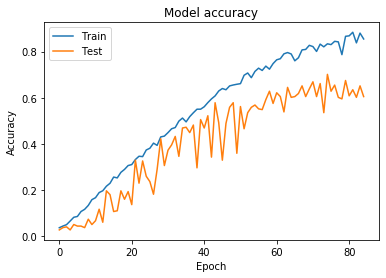

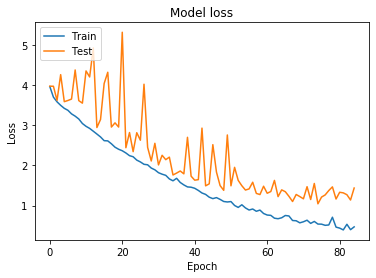

In [29]:
early_stop = EarlyStopping(patience=10)

history_2 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=100,
            verbose=2,
            callbacks=[early_stop])

plot_history([history_2])

Большой процент дропаута сильно помог с переубучением! Сохраним на состояние модели для последующих тестов.

In [30]:
model.save('best_model-augdata.h5')

#### Попробуем применить аугментацию наших изображений
 - случайный поворот на 10 градусов
 - случайное зуммирование на 10%
 - случайное изменение яркости в диапозоне \[0.7, 1.3\]
 - случайное горизонтальное отображение

Это должно привести к более стабильным результатам. Используем предыдущую архитектуру сети, т.к. она дала самые лучшие результаты.

In [8]:
model = conv_model(size=3, lr=0.001, use_dropout=True, use_batchnorm=True, use_globalpool=True)
model.summary()

W1217 07:25:03.951596 140203217426240 nn_ops.py:4283] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_6 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_6 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 56, 56, 128)       512       
_________________________________________________________________
activation_7 (Activation)    (None, 56, 56, 128)       0         
__________

W1217 07:26:01.370959 140203217426240 deprecation.py:323] From /home/mikhailm/anaconda3/envs/reinf_learn/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1217 07:26:01.636710 140203217426240 module_wrapper.py:139] From /home/mikhailm/anaconda3/envs/reinf_learn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1217 07:26:01.858319 140203217426240 module_wrapper.py:139] From /home/mikhailm/anaconda3/envs/reinf_learn/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/100
 - 198s - loss: 3.9683 - categorical_accuracy: 0.0353 - val_loss: 3.5945 - val_categorical_accuracy: 0.0469
Epoch 2/100
 - 113s - loss: 3.7136 - categorical_accuracy: 0.0406 - val_loss: 3.6835 - val_categorical_accuracy: 0.0432
Epoch 3/100
 - 113s - loss: 3.6233 - categorical_accuracy: 0.0518 - val_loss: 3.5277 - val_categorical_accuracy: 0.0465
Epoch 4/100
 - 113s - loss: 3.5740 - categorical_accuracy: 0.0547 - val_loss: 3.7913 - val_categorical_accuracy: 0.0399
Epoch 5/100
 - 113s - loss: 3.5126 - categorical_accuracy: 0.0676 - val_loss: 3.5540 - val_categorical_accuracy: 0.0631
Epoch 6/100
 - 114s - loss: 3.4805 - categorical_accuracy: 0.0723 - val_loss: 3.5656 - val_categorical_accuracy: 0.0532
Epoch 7/100
 - 112s - loss: 3.4420 - categorical_accuracy: 0.0766 - val_loss: 4.0896 - val_categorical_accuracy: 0.0432
Epoch 8/100
 - 113s - loss: 3.3906 - categorical_accuracy: 0.0855 - val_loss: 3.5302 - val_categorical_accuracy: 0.1030
Epoch 9/100
 - 114s - loss: 3.3584 - cat

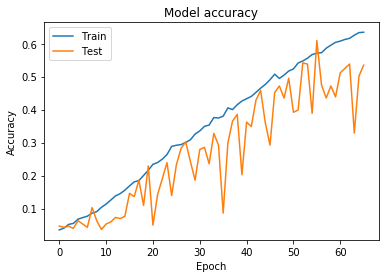

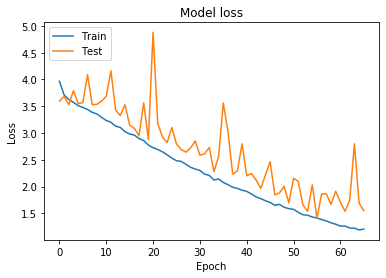

In [10]:
early_stop = EarlyStopping(patience=10)

history_ = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=100,
            verbose=2,
            callbacks=[early_stop])

plot_history([history_])

Как видно из графика сильно это не помогло. Предположение: уменьшить learning rate, возможно модель зависла на плато и сойдется еще чуть-чуть. Используем lr=0.0003, как советовал Andrej Karpathy в своем [твиттере](https://twitter.com/karpathy/status/801621764144971776) =D

In [11]:
model.optimizer = Adam(lr=0.0003)

Epoch 1/20
 - 113s - loss: 0.9489 - categorical_accuracy: 0.7220 - val_loss: 1.3387 - val_categorical_accuracy: 0.5880
Epoch 2/20
 - 114s - loss: 0.8085 - categorical_accuracy: 0.7553 - val_loss: 1.5844 - val_categorical_accuracy: 0.5914
Epoch 3/20
 - 113s - loss: 0.7608 - categorical_accuracy: 0.7654 - val_loss: 1.3064 - val_categorical_accuracy: 0.6213
Epoch 4/20
 - 114s - loss: 0.7710 - categorical_accuracy: 0.7587 - val_loss: 1.0489 - val_categorical_accuracy: 0.7076
Epoch 5/20
 - 112s - loss: 0.8355 - categorical_accuracy: 0.7449 - val_loss: 1.1500 - val_categorical_accuracy: 0.6213
Epoch 6/20
 - 112s - loss: 0.7462 - categorical_accuracy: 0.7657 - val_loss: 1.5887 - val_categorical_accuracy: 0.6578
Epoch 7/20
 - 113s - loss: 0.8778 - categorical_accuracy: 0.7351 - val_loss: 1.2737 - val_categorical_accuracy: 0.5847
Epoch 8/20
 - 112s - loss: 0.8050 - categorical_accuracy: 0.7496 - val_loss: 1.3155 - val_categorical_accuracy: 0.6013
Epoch 9/20
 - 112s - loss: 0.7751 - categorical_

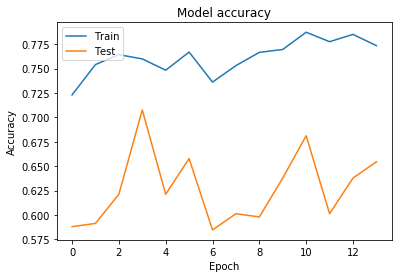

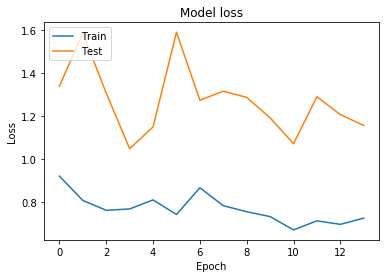

In [13]:
early_stop = EarlyStopping(patience=10)

history_ = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=20,
            verbose=2,
            callbacks=[early_stop])

plot_history([history_])

+5% точности на валидационной выборке! Неплохо. Возможно еще раз уменьшить lr... но по 2 минуты на эпоху слишком долго... Остановимся на этом и сохраним модель.

In [14]:
model.save('best_model+augdata.h5')

А что если модель без применения аугментации так же хороша? Проверим!

In [25]:
best_model = load_model('best_model-augdata.h5')
best_model.optimizer = Adam(lr=0.00001)

Epoch 1/20
 - 20s - loss: 0.4797 - categorical_accuracy: 0.8623 - val_loss: 1.6537 - val_categorical_accuracy: 0.5880
Epoch 2/20
 - 17s - loss: 0.3960 - categorical_accuracy: 0.8837 - val_loss: 1.1191 - val_categorical_accuracy: 0.6977
Epoch 3/20
 - 17s - loss: 0.3330 - categorical_accuracy: 0.9045 - val_loss: 1.3055 - val_categorical_accuracy: 0.6047
Epoch 4/20
 - 17s - loss: 0.2981 - categorical_accuracy: 0.9181 - val_loss: 1.1355 - val_categorical_accuracy: 0.6645
Epoch 5/20
 - 17s - loss: 0.2728 - categorical_accuracy: 0.9224 - val_loss: 1.6386 - val_categorical_accuracy: 0.5947
Epoch 6/20
 - 17s - loss: 0.3948 - categorical_accuracy: 0.8871 - val_loss: 1.3062 - val_categorical_accuracy: 0.6179
Epoch 7/20
 - 17s - loss: 0.3710 - categorical_accuracy: 0.8980 - val_loss: 1.3395 - val_categorical_accuracy: 0.6412
Epoch 8/20
 - 18s - loss: 0.2401 - categorical_accuracy: 0.9355 - val_loss: 1.5340 - val_categorical_accuracy: 0.6146
Epoch 9/20
 - 18s - loss: 0.3770 - categorical_accuracy:

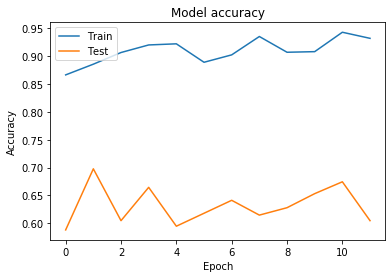

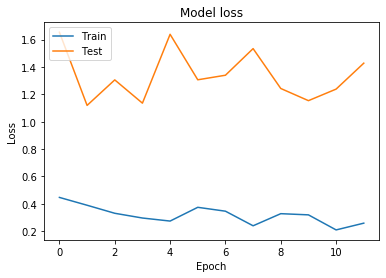

In [26]:
early_stop = EarlyStopping(patience=10)

history_ = best_model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=20,
            verbose=2,
            callbacks=[early_stop])

plot_history([history_])

Нет, не вышло. Аугментация данных все таки приносит свои плоды.

### Тестирование

Загрузим наши лучшие модели.

In [19]:
best_model_1 = load_model('1.h5')
best_model_2 = load_model('2.h5')
best_model_3 = load_model('best_model-augdata.h5')
best_model_4 = load_model('best_model+augdata.h5')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Генератор с тестовыми данными

In [20]:
test_data = pandas.read_csv('../test_pets.csv', usecols=['Category', 'Path'])
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

Found 333 validated image filenames belonging to 37 classes.


Проверим ошибку и точность обеих моделей. Результат очевиден.

In [22]:
history_1 = best_model_1.evaluate_generator(
    test_generator,
    steps=test_generator.n // batch_size,
    verbose=1)

history_2 = best_model_2.evaluate_generator(
    test_generator,
    steps=test_generator.n // batch_size,
    verbose=1)

history_3 = best_model_3.evaluate_generator(
    test_generator,
    steps=test_generator.n // batch_size,
    verbose=1)

history_4 = best_model_4.evaluate_generator(
    test_generator,
    steps=test_generator.n // batch_size,
    verbose=1)

print(f'1:\n - test loss: {history_1[0]}, test accuracy: {history_1[1]}')
print(f'2:\n - test loss: {history_2[0]}, test accuracy: {history_2[1]}')
print(f'3:\n - test loss: {history_3[0]}, test accuracy: {history_3[1]}')
print(f'4:\n - test loss: {history_4[0]}, test accuracy: {history_4[1]}')

10/10 [==============================] - 1s 89ms/step
1:
 - test loss: 8.397007790118753, test accuracy: 0.16943521607060766
2:
 - test loss: 2.655903912065829, test accuracy: 0.3588039868099745
3:
 - test loss: 1.2996498271080346, test accuracy: 0.6212624594618712
4:
 - test loss: 1.0639658837619415, test accuracy: 0.66777408756687


Original: basset_hound

1
 - american_pit_bull_terrier 0.901869
 - saint_bernard 0.053291954
 - beagle 0.040868543

2
 - basset_hound 0.89700705
 - american_pit_bull_terrier 0.07242166
 - saint_bernard 0.01048784

3
 - basset_hound 0.5467195
 - beagle 0.32127753
 - boxer 0.0801156

4
 - basset_hound 0.5987823
 - beagle 0.26649556
 - saint_bernard 0.04203651


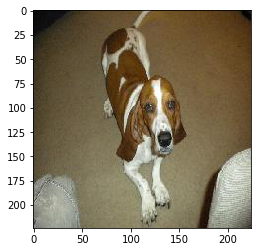

In [28]:
sample = test_generator.next()
image_array = sample[0]
categories_dict = {value: key for key, value in test_generator.class_indices.items()}
category = categories_dict[np.argmax(sample[1][0])]

predictions_1 = best_model_1.predict(image_array)[0]
predictions_2 = best_model_2.predict(image_array)[0]
predictions_3 = best_model_3.predict(image_array)[0]
predictions_4 = best_model_4.predict(image_array)[0]

best_args_1 = np.argsort(predictions_1)[::-1][:3]
best_args_2 = np.argsort(predictions_2)[::-1][:3]
best_args_3 = np.argsort(predictions_3)[::-1][:3]
best_args_4 = np.argsort(predictions_4)[::-1][:3]

print(f'Original: {category}\n')

print('1')
for i in best_args_1:
    print(' -', categories_dict[i], predictions_1[i])

print('\n2')
for i in best_args_2:
    print(' -', categories_dict[i], predictions_2[i])
    
print('\n3')
for i in best_args_3:
    print(' -', categories_dict[i], predictions_3[i])
    
print('\n4')
for i in best_args_4:
    print(' -', categories_dict[i], predictions_4[i])

plt.imshow(image_array[0])